In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-canada-products-2023-2-1m-products/amz_ca_total_products_data_processed.csv


In [2]:
!pip install sentence-transformers

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, Image, HTML
import joblib
import os


In [4]:
path="/kaggle/input/amazon-canada-products-2023-2-1m-products/amz_ca_total_products_data_processed.csv"
df_original=pd.read_csv(path)


In [5]:
df=df_original.copy()
df.head()


,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,categoryName,isBestSeller,boughtInLastMonth
0,B07CV4L6HX,"Green Leaf WW3D Wonder Extension Cord Winder, ...",https://m.media-amazon.com/images/I/81cRe0AVC4...,https://www.amazon.ca/dp/B07CV4L6HX,4.4,2876,47.69,0.00,Industrial Scientific,False,0
1,B09N1HGY74,8pcs Toilet Seat Bumpers Universal Toilet Repl...,https://m.media-amazon.com/images/I/512CpB-EP5...,https://www.amazon.ca/dp/B09N1HGY74,3.8,55,10.99,0.00,Industrial Scientific,False,100
2,B087P7538J,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,https://m.media-amazon.com/images/I/71P+qLFDFc...,https://www.amazon.ca/dp/B087P7538J,4.0,126,25.99,27.99,Industrial Scientific,False,50
3,B0822FF7YQ,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,https://m.media-amazon.com/images/I/61wfWLZRn-...,https://www.amazon.ca/dp/B0822FF7YQ,4.5,1936,21.99,30.99,Industrial Scientific,False,100
4,B08NTR8NN4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",https://m.media-amazon.com/images/I/61qJG-y1He...,https://www.amazon.ca/dp/B08NTR8NN4,4.2,46,18.99,0.00,Industrial Scientific,False,100


In [6]:
cols=list(df.columns)
cols

['asin',
 'title',
 'imgUrl',
 'productURL',
 'stars',
 'reviews',
 'price',
 'listPrice',
 'categoryName',
 'isBestSeller',
 'boughtInLastMonth']

In [7]:
cols=[col for col in cols if col not in ["productURL","listPrice","boughtInLastMonth"]]
cols

['asin',
 'title',
 'imgUrl',
 'stars',
 'reviews',
 'price',
 'categoryName',
 'isBestSeller']

In [8]:
df=df.loc[:,cols]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165926 entries, 0 to 2165925
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   asin          object 
 1   title         object 
 2   imgUrl        object 
 3   stars         float64
 4   reviews       int64  
 5   price         float64
 6   categoryName  object 
 7   isBestSeller  bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 117.7+ MB


In [10]:
df.describe().round(2)

,stars,reviews,price
count,2165926.00,2165926.00,2165926.00
mean,2.62,545.74,111.22
std,2.15,4355.22,497.67
min,0.00,0.00,0.00
25%,0.00,0.00,15.42
50%,4.00,5.00,27.42
75%,4.50,123.00,57.50
max,5.00,868865.00,40900.00


In [11]:
print(f"Total Rows:    {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Column Names:  {list(df.columns)}")
print(f"Number of Categories : {df['categoryName'].nunique()}")

Total Rows:    2,165,926
Total Columns: 8
Column Names:  ['asin', 'title', 'imgUrl', 'stars', 'reviews', 'price', 'categoryName', 'isBestSeller']
Number of Categories : 266


In [12]:
# Before cleaning
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': null_counts,
    '% Missing': null_percent
})

print(missing_df[missing_df['Missing Count'] > 0])

# Drop rows with any null value
df = df.dropna()



       Missing Count  % Missing
title              6   0.000277


In [13]:
print("\nAfter\n")

# Recalculate AFTER dropna
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': null_counts,
    '% Missing': null_percent
})

print(missing_df[missing_df['Missing Count'] > 0])

# Check duplicates
dup_count = df.duplicated(subset=['asin']).sum()
print(f"Duplicate ASINs: {dup_count:,}")



After

Empty DataFrame
Columns: [Missing Count, % Missing]
Index: []
Duplicate ASINs: 0


In [14]:
def getOutliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(len(outliers))

In [15]:
getOutliers('reviews')
getOutliers('price')

368703
273608


In [16]:
print("Before log transformation")
price_skew = df['price'].skew()
review_skew = df['reviews'].skew()
stars_skew=df['stars'].skew()
print(f'price skew : {price_skew}')
print(f'review_skew : {review_skew}')
print(f'stars_skew : {stars_skew}')

print("After log transformation")

df['price_log'] = np.log1p(df['price'])
df['review_log'] = np.log1p(df['reviews'])
price_skew = df['price_log'].skew()
review_skew = df['review_log'].skew()
stars_skew=df['stars'].skew()
print(f'price skew : {price_skew}')
print(f'review_skew : {review_skew}')
print(f'stars_skew : {stars_skew}')


Before log transformation
price skew : 14.30409335128015
review_skew : 71.8787012567291
stars_skew : -0.34442168798119516
After log transformation
price skew : -0.10032064848868136
review_skew : 0.6583178290448315
stars_skew : -0.34442168798119516


In [17]:

zero_price_count = len(df[df['price'] == 0])
print(f"Items with Price $0.00: {zero_price_count:,}")

initial_rows = len(df)

df_clean = df[df['price'] > 0].copy()

dropped_rows = initial_rows - len(df_clean)
percent_dropped = (dropped_rows / initial_rows) * 100

print(f"Dropped Rows:     {dropped_rows:,} ({percent_dropped:.2f}%)")
print(f"Remaining Rows:   {len(df_clean):,}")

# 3. Verification
# Ensure Min Price is now valid (> 0)
print(f"\n--- VERIFICATION ---")
print(f"New Min Price:    ${df_clean['price'].min():.2f}")
print(f"New Max Price:    ${df_clean['price'].max():,.2f}")

Items with Price $0.00: 177,910
Dropped Rows:     177,910 (8.21%)
Remaining Rows:   1,988,010

--- VERIFICATION ---
New Min Price:    $0.01
New Max Price:    $40,900.00


In [18]:
categories=list(df_clean['categoryName'].unique())
men_cat=[ men for men in categories if ("men's" in men.lower()) and ("women's" not in men.lower()) ]
men_cat

["Men's Shoes",
 "Men's Jewelry",
 "Men's Watches",
 "Men's Accessories",
 "Men's Clothing"]

In [19]:
def get_super_category(category_name):
    """
    Returns the super category based on a hard-coded exact match.
    """
    # 1. Men's Fashion
    men_fashion = {
        "Men's Shoes", "Men's Jewelry", "Men's Watches", "Men", 
        "Men's Clothing", "Men's Accessories", "Boys"
    }

    # 2. Women's Fashion
    women_fashion = {
        "Women's Shoes", "Women's Accessories", "Women's Handbags", 
        "Women's Watches", "Women", "Women's Jewelry", "Women's Clothing", 
        "Girls", "Luggage  Travel Gear", "Shoe, Jewelry  Watch Accessories", 
        "Clothing, Shoes  Jewellery", "Handmade Clothing, Shoes  Accessories",
        "Handmade Jewellery", "Uniforms, Work  Safety", "Novelty  Special Use Clothing",
        "Sporting Apparel", "Sport Specific Clothing"
    }

    # 3. Electronics & Computers
    electronics = {
        "Audio/Video Receivers  Amplifiers", "Digital Media Devices", "Data Storage", 
        "Televisions  Video", "TV Accessories", "Satellite Television Equipment", 
        "Televisions", "Computer Components", "Home Theatre Systems", "Electronics", 
        "Printers", "Game Hardware", "Laptop  Netbook Computer Accessories", 
        "Printer Accessories", "Car Electronics  Accessories", "Vehicle Electronics", 
        "Laptop Computers", "Camera  Photo", "Desktop Computers", 
        "Computer Cable Adapters", "Computer Security Cables", 
        "Computer Hard Drive Accessories", "Keyboards, Mice  Input Devices", 
        "Computer Uninterrupted Power Supply", "Memory Card Accessories", 
        "Cables  Accessories", "Blu-ray Players  Recorders", "DVD Players  Recorders", 
        "Home Audio Speakers", "Networking Products", "Computer Monitors", 
        "Computer Audio  Video Accessories", "USB Hubs", "Electronics  Gadgets", 
        "Memory Cards", "Computer Monitor Accessories", "Computer Accessories", 
        "USB Gadgets", "Tablet Accessories", "Television Projectors", 
        "3D Printing  Scanning", "Cell Phones"
    }

    # 4. Beauty, Health & Personal Care
    beauty_health = {
        "Perfume  Cologne", "Beauty", "Bath  Body", "Salon  Spa Equipment", 
        "Shaving  Hair Removal Products", "Skin Care Products", "Tattooing Supplies", 
        "Beauty Tools  Accessories", "Makeup", "Health Care Products", 
        "Vision Care Products", "Bath Products", "Sex  Sensuality Products", 
        "Oral Hygiene Products", "Hair Care", "Nail Polish  Nail Decoration Products", 
        "Luxury Beauty", "Handmade Beauty  Grooming Products", "Diet  Nutrition Products", 
        "Women's Health  Family Planning", "Health  Personal Care", 
        "Medical Supplies  Equipment", "Vitamins, Minerals  Supplements", "Wellness",
        "Professional Medical Supplies", "Occupational Health  Safety Products"
    }

    # 5. Toys, Kids & Baby
    toys_kids = {
        "Pogo Sticks  Hopping Toys", "Swimming Pool  Outdoor Water Toys", 
        "Play Sets  Playground Equipment", "Sandboxes  Beach Toys", 
        "Baby  Toddler Toys", "Kites  Wind Spinners", "Building  Construction Toys", 
        "Baby  Child Care Products", "Handmade Toys  Games", "Dolls  Accessories", 
        "Baby", "Kids' Play Tents  Tunnels", "Kids' Slumber Bags", 
        "Toy Sports Equipment", "Toys  Games", "Stuffed  Plush Animals", 
        "Collectible Toys", "Bikes, Scooters  Ride-Ons", 
        "Action Figures, Maquettes  Busts", "Handmade Baby Products", 
        "Games  Accessories", "Child Safety Car Seats", "Baby Strollers", 
        "Outdoor Play Toys", "Toy Gardening Equipment", 
        "Children's Outdoor Inflatable Bouncers  Bouncy Castles", "Toy Vehicles", 
        "Kids' Ball Pits  Accessories", "Toy Foam Blasters  Guns", 
        "Bubble Blowing Products", "STEM", "Science Education Supplies", "Hobbies"
    }

    # 6. Automotive & Industrial
    auto_industrial = {
        "Industrial  Scientific", "Motorcycle Accessories  Parts", 
        "Automotive Tires  Wheels", "Material Transport Equipment", 
        "Automotive Tools  Equipment", "RV Parts  Accessories", "Industrial Materials", 
        "Automotive Care", "Automotive", "Oils  Fluids", 
        "Automotive Replacement Parts", "Power Transmission Products", 
        "Industrial Hardware", "Material Handling", "Automotive Exterior Accessories", 
        "Automotive Interior Accessories", "Lab  Scientific Products", 
        "Electrical Equipment", "Hydraulics, Pneumatics  Plumbing", "Fasteners", 
        "Paint, Body  Trim Products", "Abrasive  Finishing Products", 
        "Commerical Door Products", "Test, Measure  Inspect", "Filtration"
    }

    # 7. Home, Kitchen & Garden
    home_garden = {
        "Dishwashing Supplies", "Fresh Flowers  Indoor Plants", "Arts  Crafts Supplies", 
        "Building Supplies", "Hardware", "Door Hardware  Locks", "Furniture Hardware", 
        "Gate Hardware", "Mailboxes  Accessories", "Locks  Hasps", 
        "Bathroom Hardware", "Hardware Hooks", "Window Hardware", "Outdoor Décor", 
        "Kitchen Utensils  Gadgets", "Tableware", "Household Cleaning Tools", 
        "Household Cleaning", "Laundry Supplies", "Bedding", "Handmade Home Décor", 
        "Home Storage  Organization", "Patio, Lawn  Garden", 
        "Kitchen Storage  Organization", "Water Coolers, Filters  Cartridges", 
        "Janitorial  Sanitation Supplies", "Home  Kitchen", 
        "Irons, Steamers  Accessories", "Weather Thermometers", 
        "Handmade Kitchen  Dining", "Outdoor Cooking", 
        "Paper  Plastic Household Supplies", "Indoor Insect  Pest Control", 
        "Sewing, Craft  Hobby", "Home Décor", "Household Supplies", 
        "Hardware Adhesives  Sealers", "Garage Door Hardware", 
        "Shelf Brackets  Supports", "Furniture", "Handmade Artwork", 
        "Handmade Bedding", "Smart Home", "Patio Furniture  Accessories", 
        "Kitchen Cookware", "Kitchen  Dining", "Kitchen Knives  Cutlery Accessories", 
        "Heating Cooling  Air Quality", "Large Appliances", 
        "Garden Structures  Germination Equipment", "Outdoor Heating  Cooling", 
        "Barware", "Small Appliances", "Home Textiles", "Vacuums  Floor Care", 
        "Handmade Stationery  Party Supplies", "Building Materials", 
        "Cabinet Hardware", "House Numbers, Plaques  Signs", "Tarps  Tie-Downs", 
        "Cat Supplies", "Musical Instruments, Stage  Studio", 
        "Nursery Furniture, Bedding  Décor", "Kitchen  Bath Fixtures", 
        "Household Batteries", "Plants Seeds  Bulbs", "Home Brewing  Wine Making", 
        "Air Freshener Supplies", "Artwork", "Handmade Furniture", 
        "Stationery  Party Supplies", "Dog Supplies", "Pet Supplies", "Pest Control", 
        "Backyard Birding", "Handmade in Canada", "Office Products", 
        "Food Service Equipment  Supplies", "Cigarette Lighters", 
        "Beanbag  Foot Bags"
    }

    # 8. Tools & Improvement
    tools = {
        "Nails, Screws  Fasteners", "Ladders", "Scaffolding Equipment", "Hand Tools", 
        "Job Site Lighting", "Cutting Tools", "Power  Hand Tools", 
        "Tools  Home Improvement", "Power Tools  Hand Tools", "Flashlights"
    }

    # 9. Sports & Outdoors
    sports = {
        "Cycling Equipment", "Awards", "Snow  Ice Sports", 
        "Outdoor Power  Lawn Equipment", "Outdoor Storage  Housing", 
        "Pools, Hot Tubs  Supplies", "Golf Equipment", "Sports  Outdoors", 
        "Farming  Urban Agriculture", "Outdoor Lighting Products", 
        "Martial Arts  Combat Sports", "Outdoor Gear", "Hunting  Fishing", 
        "Outdoor Recreation Apparel  Equipment", "Leisure Sports  Game Room", 
        "Team Sports", "Boating  Watersports", "Sports Fan Shop", "Action Sports", 
        "Exercise  Fitness Equipment", "Camping  Hiking Equipment"
    }

    # 10. Food & Grocery
    food = {
        "International Food Market", "Coffee, Tea  Espresso", 
        "Breakfast Cereal", "Grocery"
    }

    # --- MATCHING LOGIC ---
    cat = category_name.strip()
    
    if cat in men_fashion: return "Men's Fashion"
    if cat in women_fashion: return "Women's Fashion"
    if cat in electronics: return "Electronics & Computers"
    if cat in beauty_health: return "Beauty, Health & Personal Care"
    if cat in toys_kids: return "Toys, Kids & Baby"
    if cat in auto_industrial: return "Automotive & Industrial"
    if cat in tools: return "Tools & Home Improvement"
    if cat in sports: return "Sports & Outdoors"
    if cat in food: return "Food & Grocery"
    if cat in home_garden: return "Home, Kitchen & Garden"
    
    # Fallback for anything not in the list
    return "Home, Kitchen & Garden" 


# Apply the func
df_clean['super_category'] = df_clean['categoryName'].apply(get_super_category)

#counts
print("--- Super Category Distribution ---")
print(df_clean['super_category'].value_counts())


print("\n--- Sample: Food & Grocery ---")
print(df_clean[df_clean['super_category'] == 'Food & Grocery']['categoryName'].head(5).tolist())

print("\n--- Sample: Women's Fashion ---")
print(df_clean[df_clean['super_category'] == "Women's Fashion"]['categoryName'].head(5).tolist())

--- Super Category Distribution ---
super_category
Home, Kitchen & Garden            536337
Electronics & Computers           267545
Beauty, Health & Personal Care    239023
Women's Fashion                   223868
Toys, Kids & Baby                 207043
Automotive & Industrial           189852
Sports & Outdoors                 142624
Men's Fashion                     104456
Tools & Home Improvement           54746
Food & Grocery                     22516
Name: count, dtype: int64

--- Sample: Food & Grocery ---
['International Food Market', 'International Food Market', 'International Food Market', 'International Food Market', 'International Food Market']

--- Sample: Women's Fashion ---
["Women's Shoes", "Women's Shoes", "Women's Shoes", "Women's Shoes", "Women's Shoes"]


In [20]:
category_df = df_clean.groupby('super_category')['categoryName'].unique().reset_index()
for _, row in category_df.iterrows():
    print(f"Super category: {row['super_category']}")
    print(f"Categories: {row['categoryName']}")
    print("------")


Super category: Automotive & Industrial
Categories: ['Industrial  Scientific' 'Motorcycle Accessories  Parts'
 'Automotive Tires  Wheels' 'Material Transport Equipment'
 'Automotive Tools  Equipment' 'RV Parts  Accessories'
 'Industrial Materials' 'Automotive Care' 'Automotive' 'Oils  Fluids'
 'Automotive Replacement Parts' 'Power Transmission Products'
 'Test, Measure  Inspect' 'Commerical Door Products' 'Filtration'
 'Industrial Hardware' 'Material Handling'
 'Automotive Exterior Accessories' 'Automotive Interior Accessories'
 'Lab  Scientific Products' 'Electrical Equipment'
 'Abrasive  Finishing Products' 'Hydraulics, Pneumatics  Plumbing'
 'Fasteners' 'Paint, Body  Trim Products']
------
Super category: Beauty, Health & Personal Care
Categories: ['Perfume  Cologne' 'Beauty' 'Bath  Body' 'Salon  Spa Equipment'
 'Shaving  Hair Removal Products' 'Skin Care Products'
 'Tattooing Supplies' 'Beauty Tools  Accessories' 'Makeup'
 'Occupational Health  Safety Products' 'Vision Care Product

In [21]:
print(f"Total Rows:    {len(df_clean):,}")
print(f"Total Columns: {len(df_clean.columns)}")
print(f"Column Names:  {list(df_clean.columns)}")


Total Rows:    1,988,010
Total Columns: 11
Column Names:  ['asin', 'title', 'imgUrl', 'stars', 'reviews', 'price', 'categoryName', 'isBestSeller', 'price_log', 'review_log', 'super_category']


In [22]:
len(df_clean[df_clean['reviews']>=130])
cat_df=pd.DataFrame(df_clean[(df_clean['reviews']>=20) ]['super_category'].value_counts())
fil=cat_df[cat_df['count']>10000]
print((fil))
fil.sum()
df_clean=df_clean[(df_clean['reviews']>=20) ]

                                 count
super_category                        
Home, Kitchen & Garden          215264
Beauty, Health & Personal Care  104569
Electronics & Computers         100700
Women's Fashion                  95589
Automotive & Industrial          83068
Sports & Outdoors                77574
Toys, Kids & Baby                65061
Men's Fashion                    55837
Tools & Home Improvement         25005
Food & Grocery                   14624


In [23]:
df_clean.groupby(['categoryName','super_category'])['categoryName'].value_counts().sort_values(ascending=False)

categoryName                        super_category                
Beauty                              Beauty, Health & Personal Care    16535
Electronics                         Electronics & Computers           15161
Luggage  Travel Gear                Women's Fashion                   13995
Men                                 Men's Fashion                     12509
Women                               Women's Fashion                   12157
                                                                      ...  
Handmade Beauty  Grooming Products  Beauty, Health & Personal Care       38
Scaffolding Equipment               Tools & Home Improvement             26
Handmade Toys  Games                Toys, Kids & Baby                    16
Handmade Baby Products              Toys, Kids & Baby                    11
Handmade Furniture                  Home, Kitchen & Garden                1
Name: count, Length: 265, dtype: int64

In [24]:
# SAMPLES_PER_CATEGORY = 10000  # Adjust this number as needed

# def sample_category(group, n=SAMPLES_PER_CATEGORY):
#     if len(group) < n:
#         return group
#     return group.sample(n, random_state=42) # random_state ensures reproducibility
    
# df_sampled = df_sampled.groupby('super_category', group_keys=False).apply(sample_category)

# df_sampled = df_sampled.reset_index(drop=True)

# print("--- Counts After Sampling ---")
# print(df_sampled['super_category'].value_counts())

# print(f"\nTotal rows in sampled dataset: {df_sampled.shape[0]}")
FRAC = 0.10  # 10%

df_sampled = (
    df_clean
    .groupby('super_category', group_keys=False)
    .apply(lambda g: g.sample(frac=FRAC, random_state=42))
    .reset_index(drop=True)
)

print("--- Counts After Sampling ---")
print(df_sampled['super_category'].value_counts())

print(f"\nTotal rows in sampled dataset: {df_sampled.shape[0]}")


# df_sampled=df_clean

--- Counts After Sampling ---
super_category
Home, Kitchen & Garden            21526
Beauty, Health & Personal Care    10457
Electronics & Computers           10070
Women's Fashion                    9559
Automotive & Industrial            8307
Sports & Outdoors                  7757
Toys, Kids & Baby                  6506
Men's Fashion                      5584
Tools & Home Improvement           2500
Food & Grocery                     1462
Name: count, dtype: int64

Total rows in sampled dataset: 83728


/tmp/ipykernel_55/477101144.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=FRAC, random_state=42))


In [25]:
df_sampled.groupby(['categoryName','super_category'])['categoryName'].value_counts().sort_values(ascending=False)

categoryName               super_category                
Beauty                     Beauty, Health & Personal Care    1725
Electronics                Electronics & Computers           1574
Luggage  Travel Gear       Women's Fashion                   1383
Men                        Men's Fashion                     1247
Women                      Women's Fashion                   1194
                                                             ... 
Handmade Kitchen  Dining   Home, Kitchen & Garden               3
Pogo Sticks  Hopping Toys  Toys, Kids & Baby                    3
Scaffolding Equipment      Tools & Home Improvement             2
Handmade Toys  Games       Toys, Kids & Baby                    1
Handmade Baby Products     Toys, Kids & Baby                    1
Name: count, Length: 264, dtype: int64

In [26]:
category_counts = df_sampled.groupby('super_category')['categoryName'].value_counts()
category_counts = category_counts.reset_index(name='count')
print(category_counts)


              super_category                           categoryName  count
0    Automotive & Industrial           Automotive Replacement Parts    837
1    Automotive & Industrial          Motorcycle Accessories  Parts    644
2    Automotive & Industrial            Automotive Tools  Equipment    636
3    Automotive & Industrial                  RV Parts  Accessories    566
4    Automotive & Industrial                 Industrial  Scientific    495
..                       ...                                    ...    ...
259          Women's Fashion                       Women's Handbags    377
260          Women's Fashion                       Sporting Apparel    251
261          Women's Fashion                        Women's Watches    219
262          Women's Fashion                     Handmade Jewellery     29
263          Women's Fashion  Handmade Clothing, Shoes  Accessories      8

[264 rows x 3 columns]


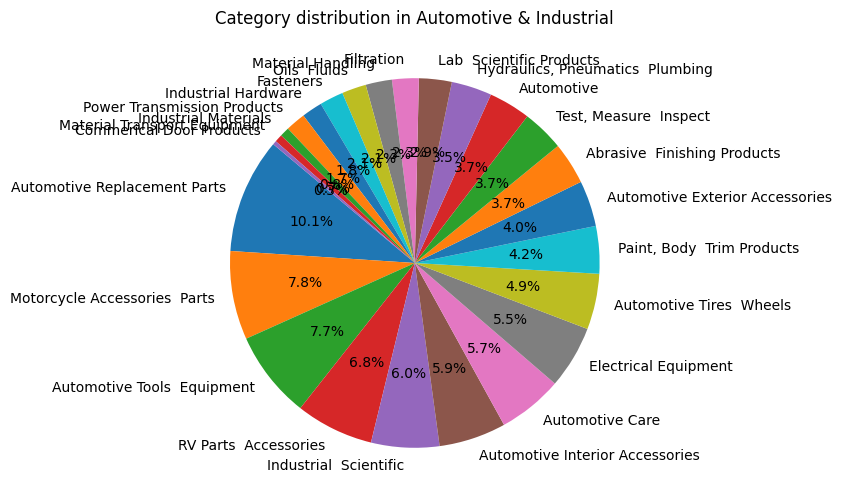

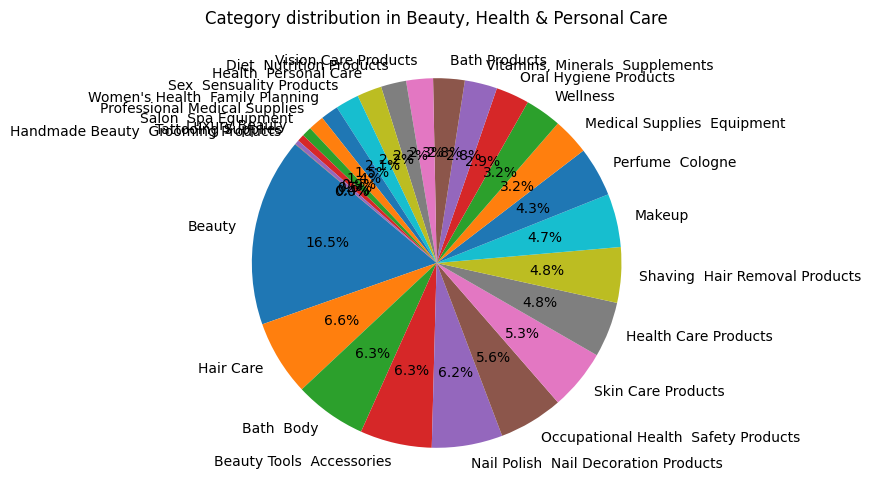

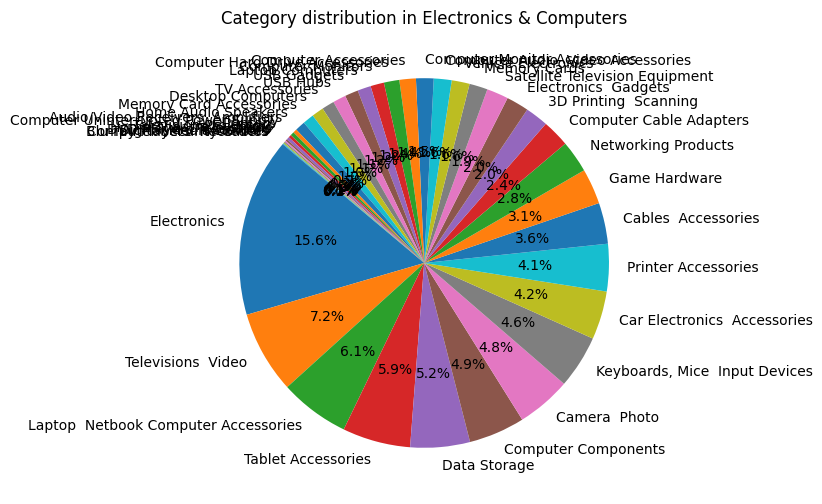

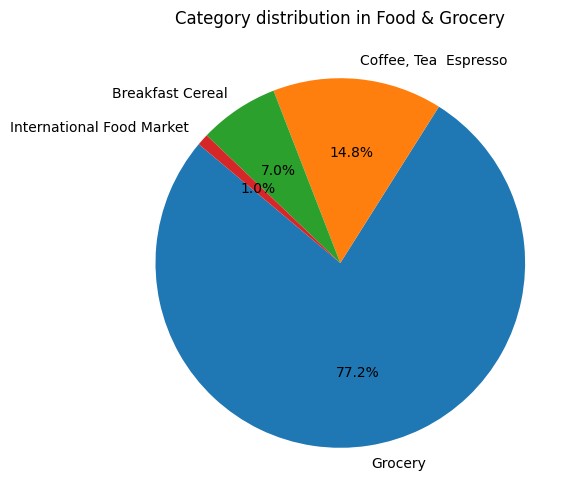

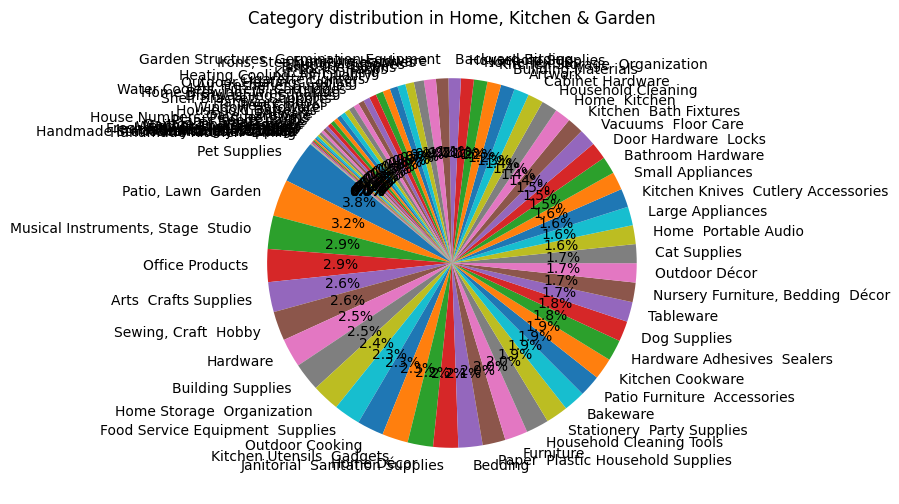

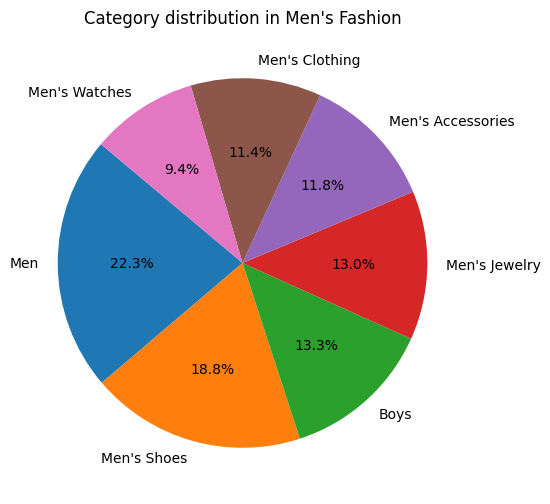

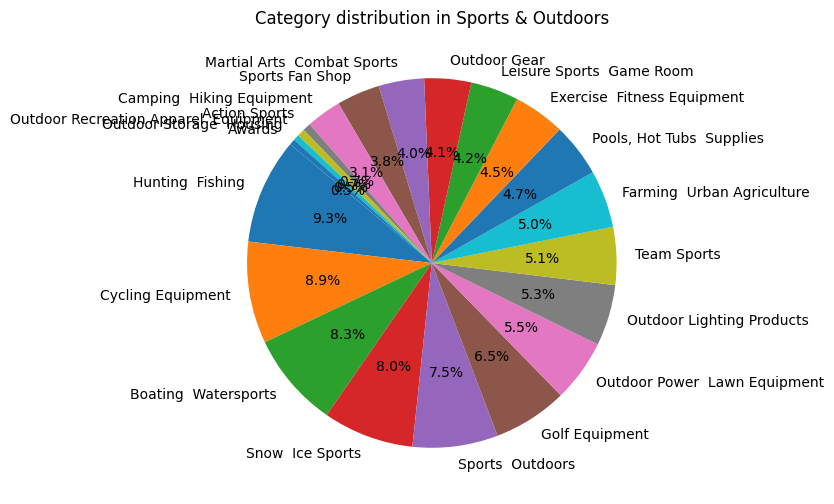

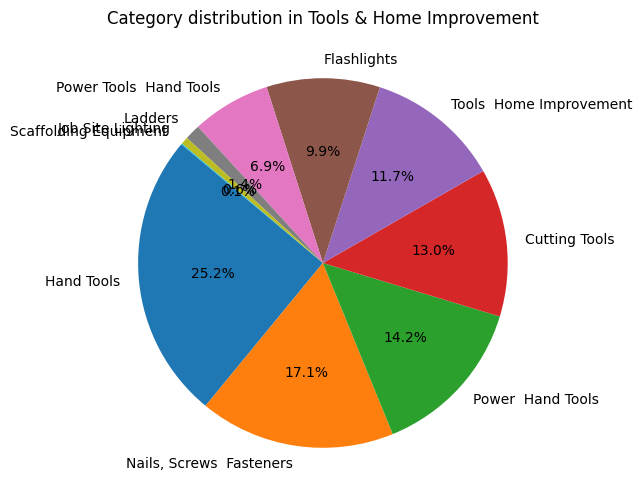

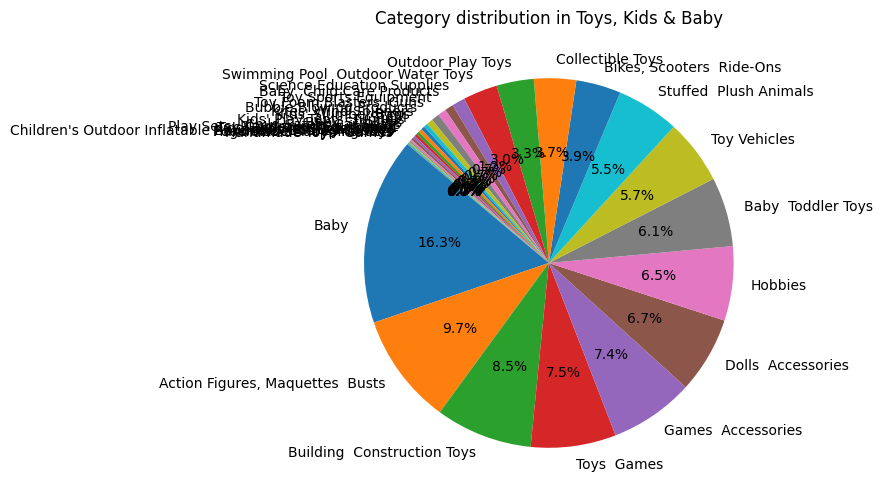

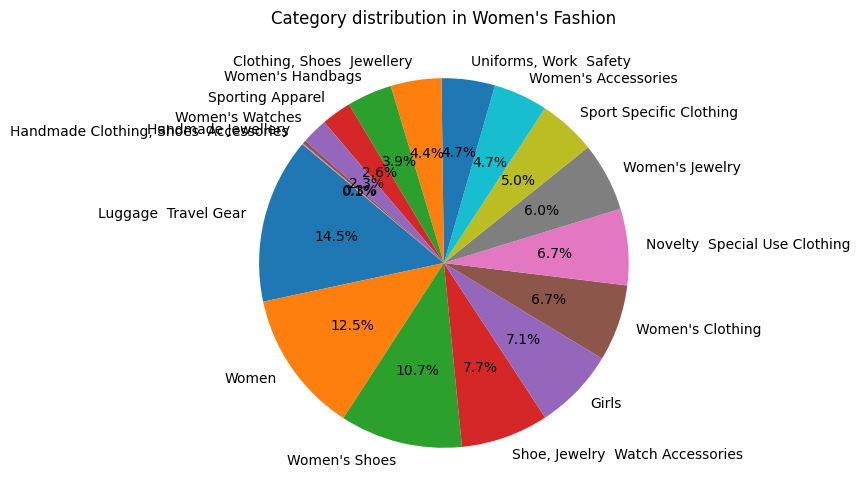

In [27]:
super_categories = category_counts['super_category'].unique()

for sc in super_categories:
    counts = category_counts[category_counts['super_category'] == sc]
    plt.figure(figsize=(6,6))
    plt.pie(counts['count'], labels=counts['categoryName'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Category distribution in {sc}')
    plt.show()


In [28]:
print("Before log transformation")
price_skew = df_sampled['price'].skew()
review_skew = df_sampled['reviews'].skew()
stars_skew=df_sampled['stars'].skew()
print(f'price skew : {price_skew}')
print(f'review_skew : {review_skew}')
print(f'stars_skew : {stars_skew}')




Before log transformation
price skew : 14.54569521323367
review_skew : 45.16867466730555
stars_skew : -1.467730829481698


In [29]:
print("After log transformation")

df_sampled['price_log'] = np.log1p(df_sampled['price'])
df_sampled['review_log'] = np.log1p(df_sampled['reviews'])
df_sampled['star_log'] = np.log1p(df_sampled['stars'])

price_skew = df_sampled['price_log'].skew()
review_skew = df_sampled['review_log'].skew()
print(f'price skew : {price_skew}')
print(f'review_skew : {review_skew}')
print(f'stars_skew : {stars_skew}')

After log transformation
price skew : 0.9196798852646766
review_skew : 0.6057734620475189
stars_skew : -1.467730829481698


array([[<Axes: title={'center': 'stars'}>,
        <Axes: title={'center': 'reviews'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'price_log'}>],
       [<Axes: title={'center': 'review_log'}>,
        <Axes: title={'center': 'star_log'}>]], dtype=object)

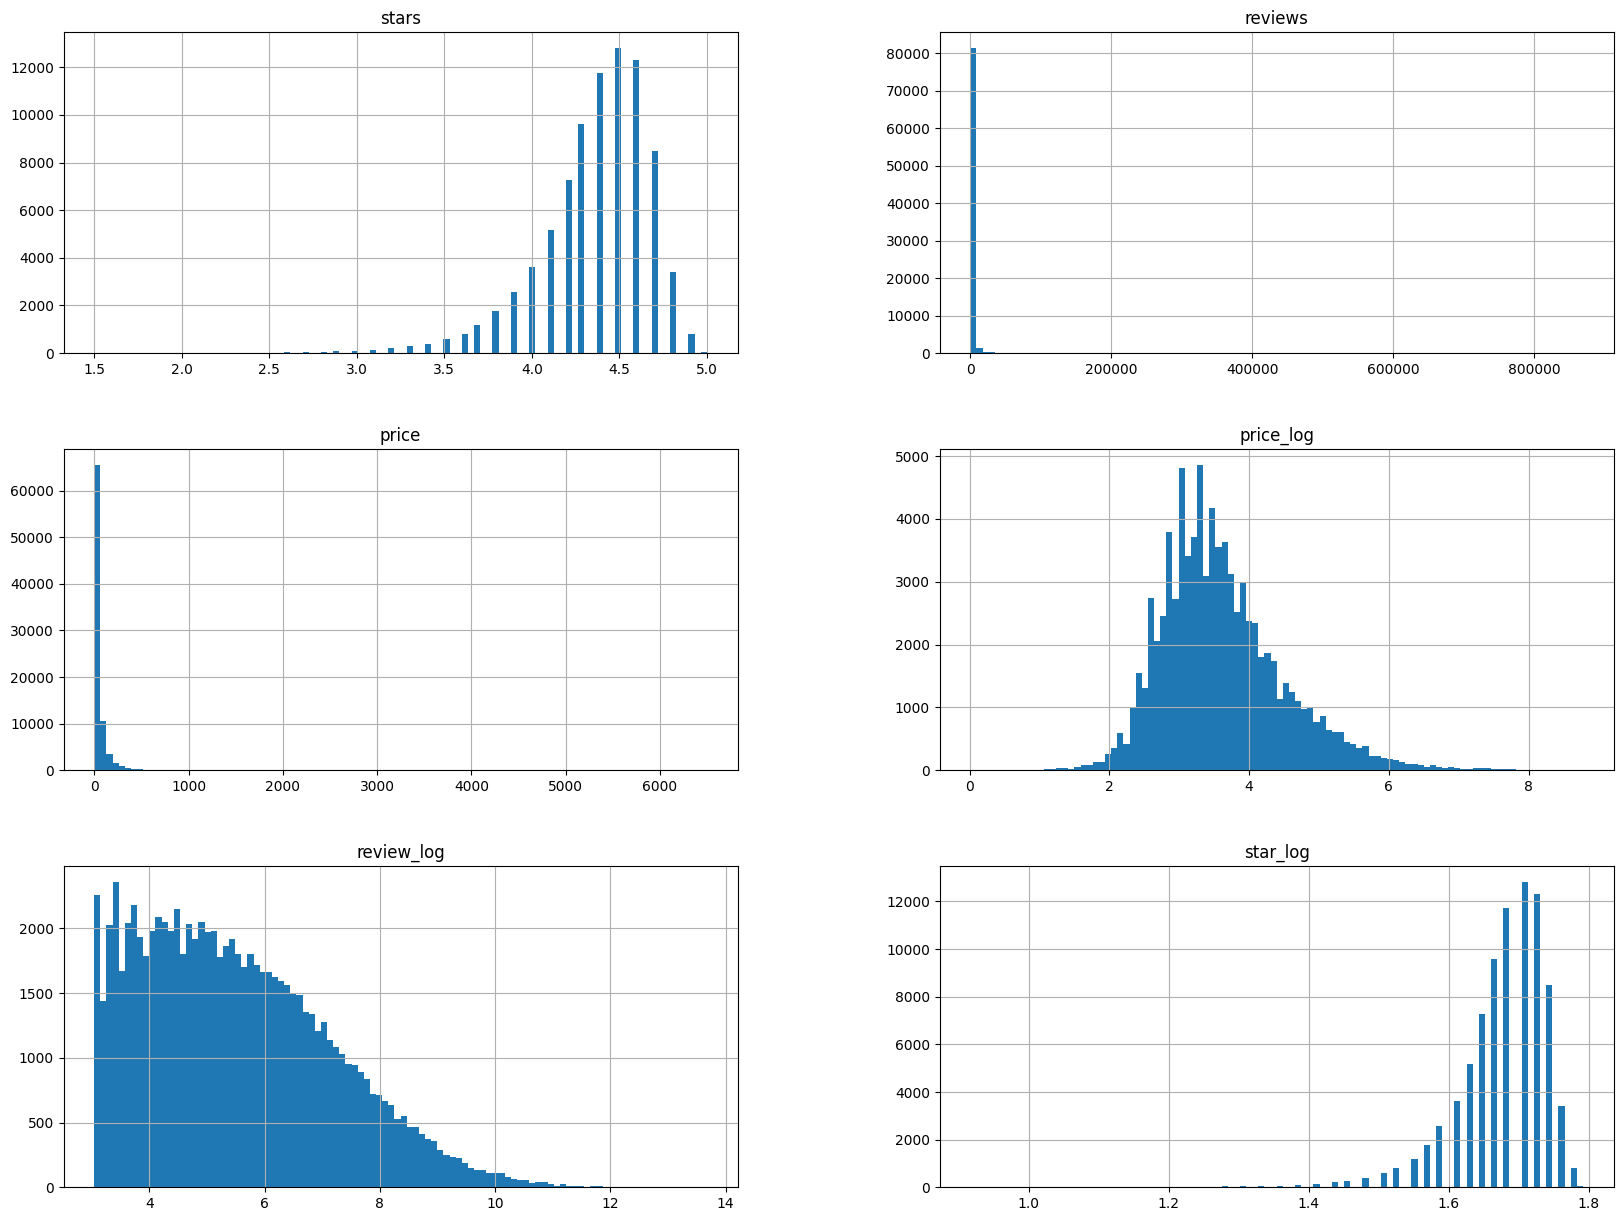

In [30]:
df_sampled.hist(bins=100,figsize=(20,15))

In [31]:
# #feature engineering ,combining texts
# #first method
# df_sampled['semantic_text'] = (
#     df_sampled['title'].fillna('') + " " + 
#     # df_sampled['categoryName'].fillna('') + " " +
#     df_sampled['super_category'].fillna('')
# ).str.lower()
#second method

def create_enriched_text(row):
    return f"Category: {row['super_category']}. Product: {row['title']}"

df_sampled['semantic_text'] = df_sampled.apply(create_enriched_text, axis=1)

print("Sample Entry:", df_sampled['semantic_text'].iloc[0])

Sample Entry: Category: Automotive & Industrial. Product: DCXFGA Vrsgs 3 in 1 High Protection Car Spray, Vrsgs Car Wax, Vrsgs Car Polish, Vrsgs Car Spray, Zoxdo 3 in 1 Ceramic Car Coating Spray, Car Nano Ceramic Crystal Coating Spray Agent (3 Pcs 100 Ml)


In [32]:
print(f"Sample Text: {df_sampled['semantic_text'].iloc[0][:80]}...")


Sample Text: Category: Automotive & Industrial. Product: DCXFGA Vrsgs 3 in 1 High Protection ...


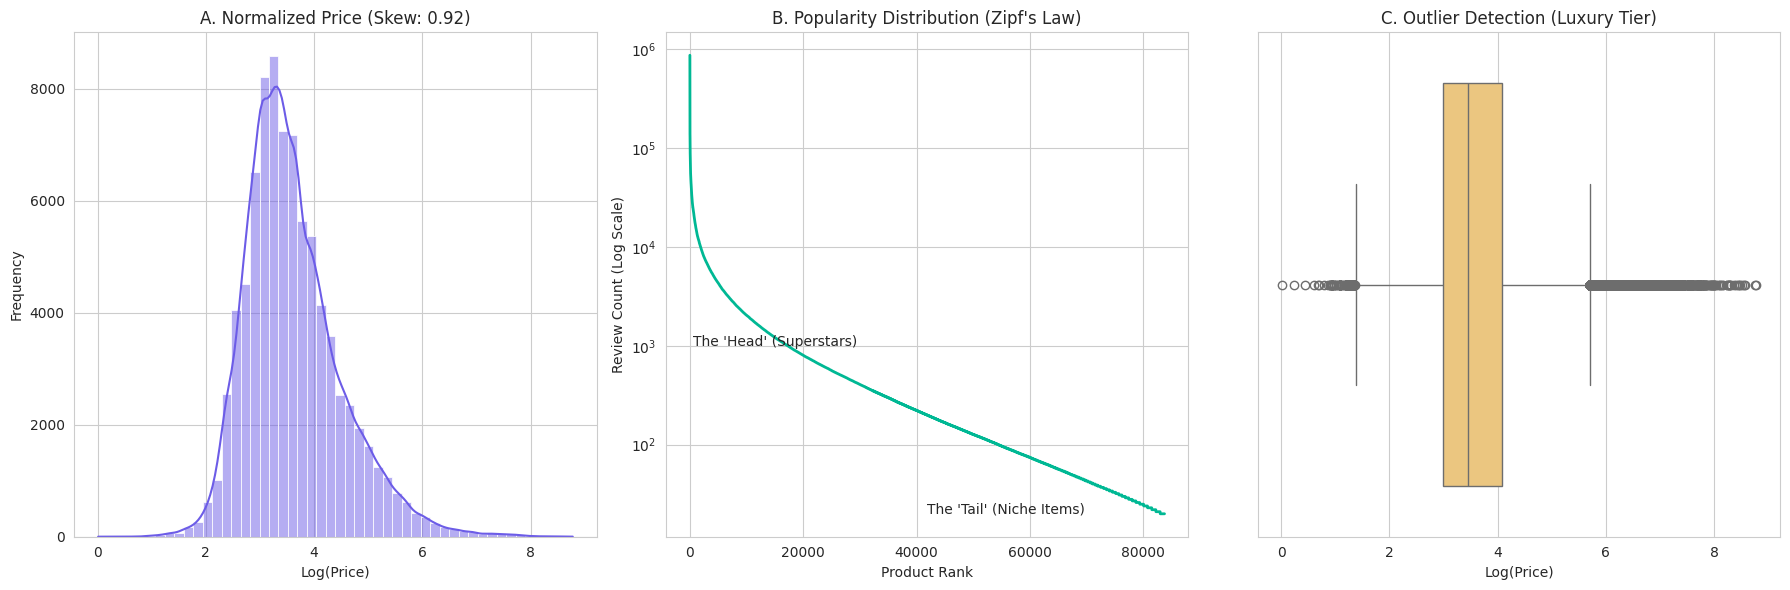


[Validation] Current Review Skew: 0.61 (Confirming Plot B)


/tmp/ipykernel_55/294339208.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


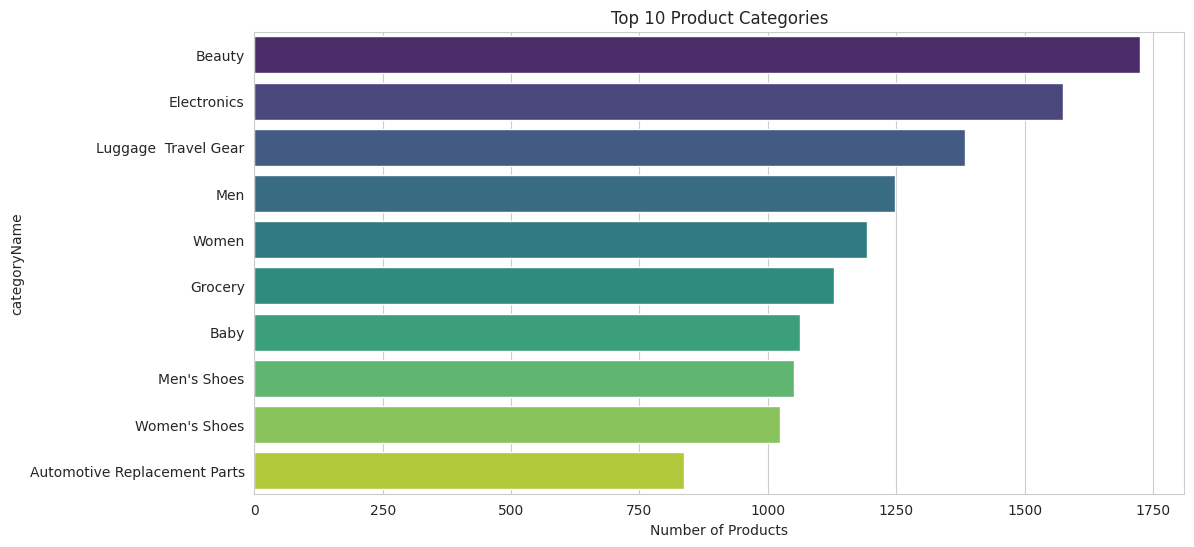

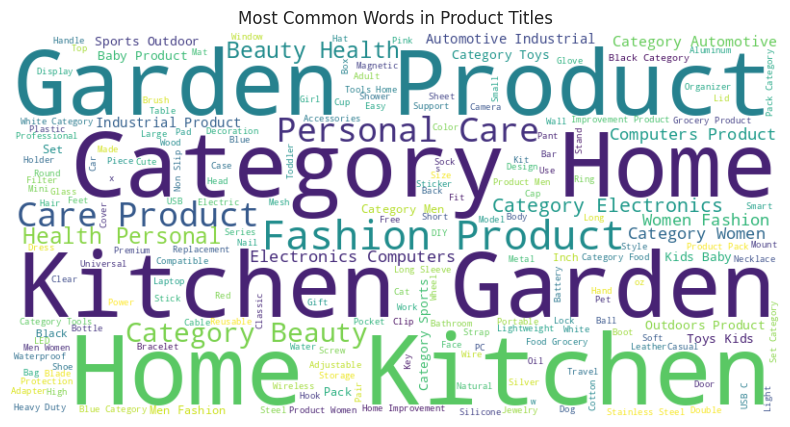

In [34]:


plt.figure(figsize=(18, 6))
sns.set_style("whitegrid") 

# PLOT A: (Log-Price Distribution) 

plt.subplot(1, 3, 1)
sns.histplot(df_sampled['price_log'], bins=50, kde=True, color='#6c5ce7')
plt.title(f"A. Normalized Price (Skew: {price_skew:.2f})")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")

# PLOT B Market Structure
plt.subplot(1, 3, 2)
sorted_reviews = df_sampled['reviews'].sort_values(ascending=False).reset_index(drop=True)
plt.plot(sorted_reviews, color='#00b894', linewidth=2)
plt.yscale('log') 
plt.title("B. Popularity Distribution (Zipf's Law)")
plt.xlabel("Product Rank")
plt.ylabel("Review Count (Log Scale)")
plt.text(500, 1000, "The 'Head' (Superstars)", fontsize=10)
plt.text(len(df_sampled)/2, 20, "The 'Tail' (Niche Items)", fontsize=10)

#PLOT C:Outliers
plt.subplot(1, 3, 3)
sns.boxplot(x=df_sampled['price_log'], color='#fdcb6e')
plt.title("C. Outlier Detection (Luxury Tier)")
plt.xlabel("Log(Price)")

plt.tight_layout()
plt.show()

current_review_skew = df_sampled['review_log'].skew()
print(f"\n[Validation] Current Review Skew: {current_review_skew:.2f} (Confirming Plot B)")
#PLOT D:Category Dominance
plt.figure(figsize=(12, 6))
top_categories = df_sampled['categoryName'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title("Top 10 Product Categories")
plt.xlabel("Number of Products")
plt.show()

# --- PLOT E: Word Cloud 
from wordcloud import WordCloud
text_corpus = " ".join(df_sampled['semantic_text'].sample(10000).values) # Sample to save memory
wc = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Product Titles")
plt.show()

       PHASE 4.5: DEEP DIVE VISUALIZATION


/tmp/ipykernel_55/1324200675.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis", ax=axes[0, 0])


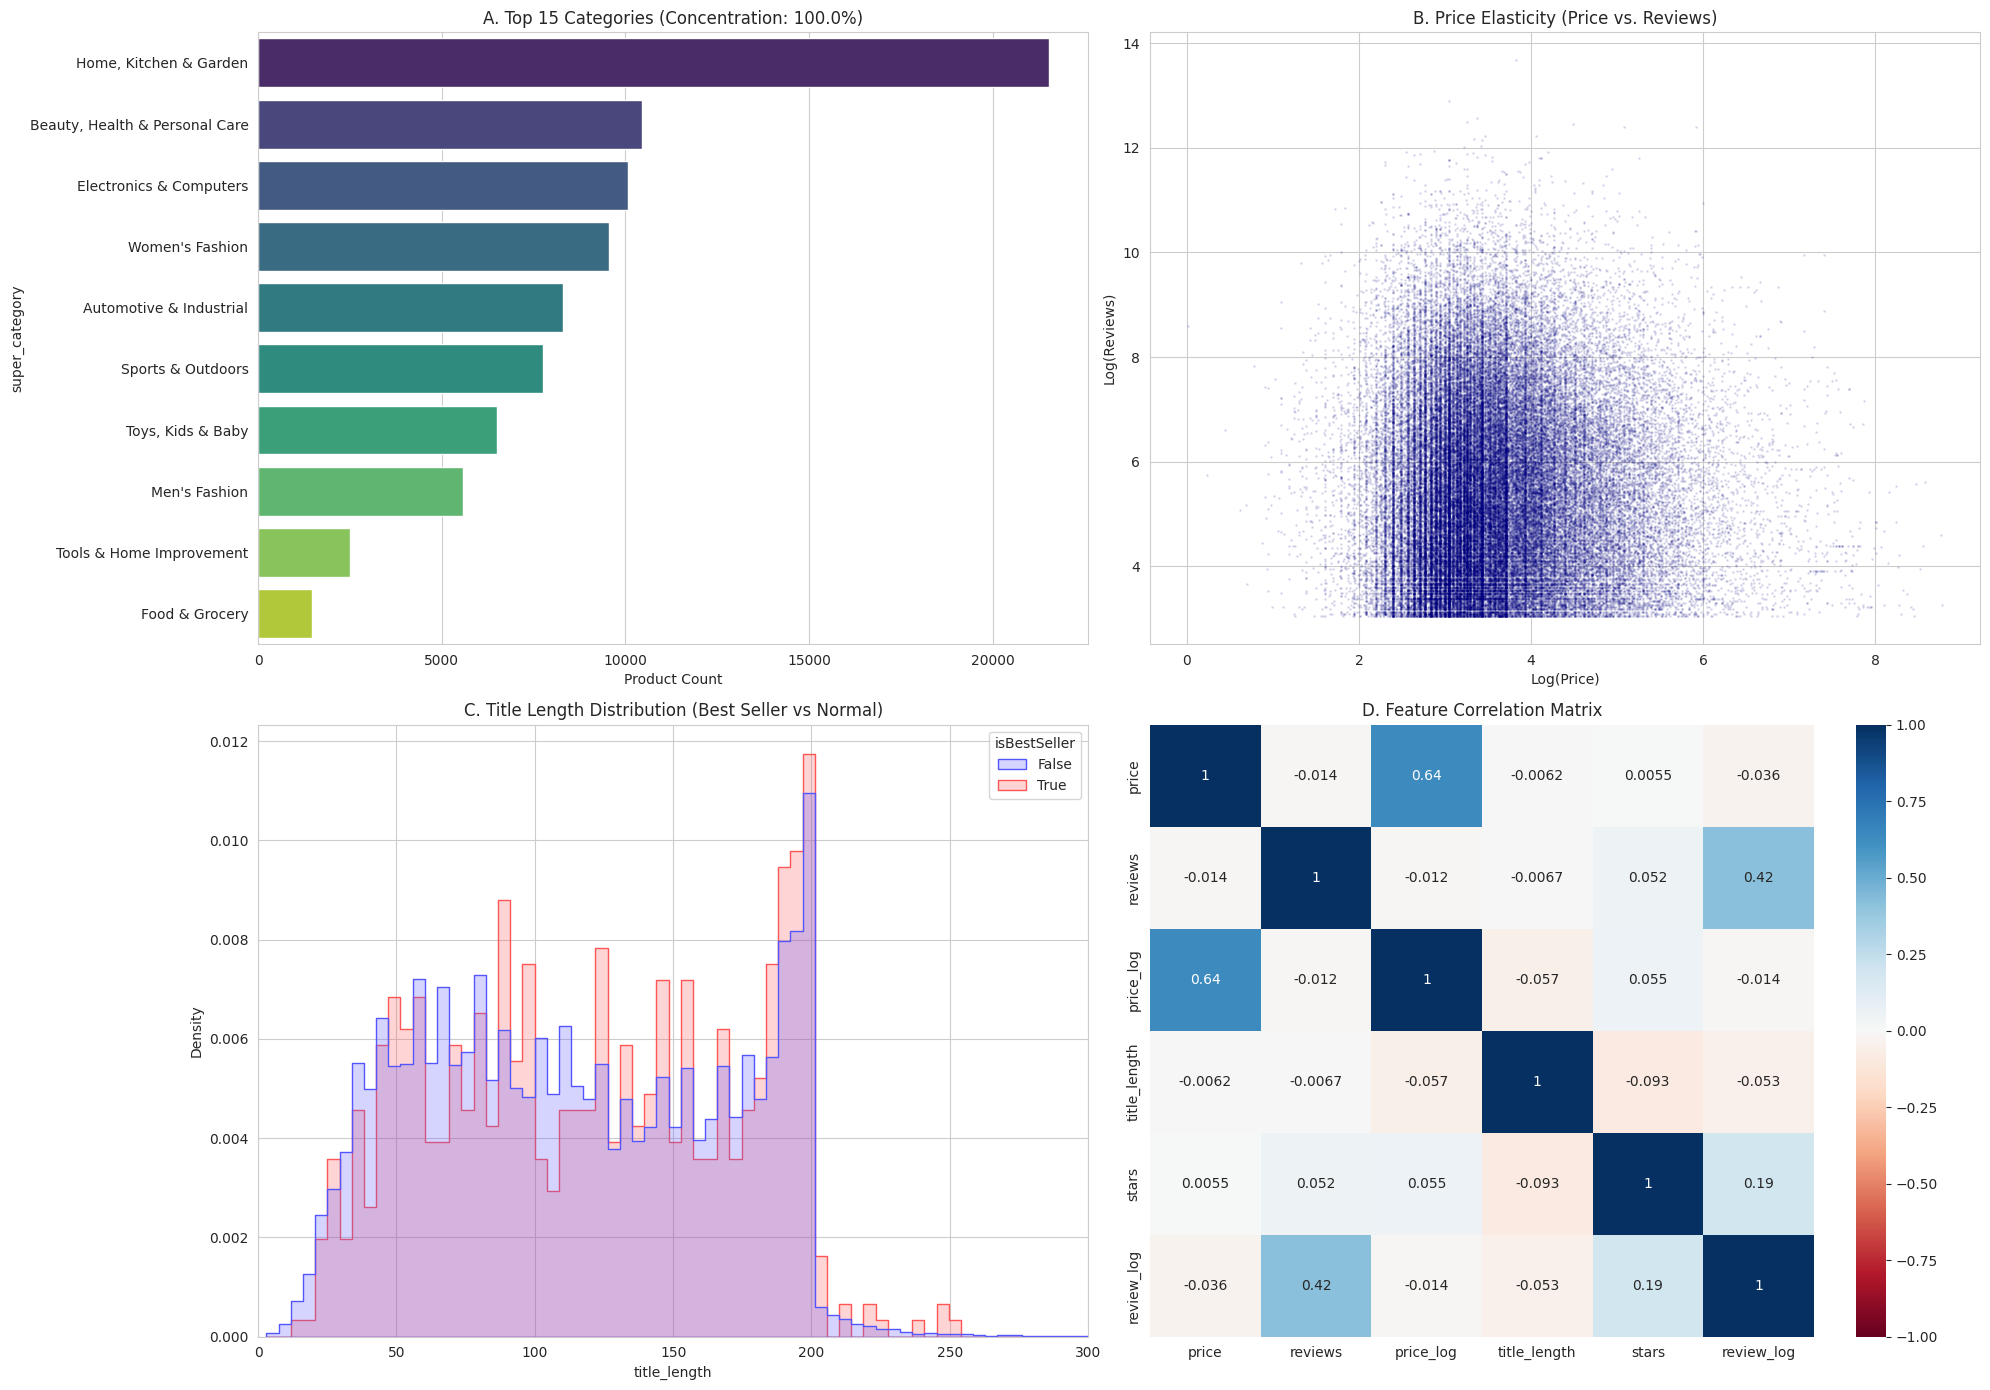

In [35]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*50)
print("       PHASE 4.5: DEEP DIVE VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
sns.set_style("whitegrid")

# PLOT 1: COMPOSITION
top_cats = df_sampled['super_category'].value_counts().head(15)
sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title(f"A. Top 15 Categories (Concentration: {top_cats.sum()/len(df_sampled):.1%})")
axes[0, 0].set_xlabel("Product Count")

# --- PLOT 2: PRICE ELASTICITY (Do cheap items sell more?) ---
# Research Question: Is there a correlation between Price and Popularity?
# We use Log-Log scale because both variables follow Power Laws.
axes[0, 1].scatter(df_sampled['price_log'], np.log1p(df_sampled['reviews']), 
                   alpha=0.1, color='navy', s=1) # Alpha=0.1 allows us to see density
axes[0, 1].set_title("B. Price Elasticity (Price vs. Reviews)")
axes[0, 1].set_xlabel("Log(Price)")
axes[0, 1].set_ylabel("Log(Reviews)")

# PLOT 3: TEXT STRUCTURAL ANALYSIS 
df_sampled['title_length'] = df_sampled['title'].astype(str).apply(len)
sns.histplot(data=df_sampled, x='title_length', hue='isBestSeller', 
             element="step", stat="density", common_norm=False, palette='seismic', ax=axes[1, 0])
axes[1, 0].set_title("C. Title Length Distribution (Best Seller vs Normal)")
axes[1, 0].set_xlim(0, 300) # Cap at 300 chars to ignore outliers

# --- PLOT 4:CORRELATION
corr_cols = ['price', 'reviews', 'price_log', 'title_length','stars','review_log']
corr_matrix = df_sampled[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0, ax=axes[1, 1])
axes[1, 1].set_title("D. Feature Correlation Matrix")

plt.tight_layout()
plt.show()

In [36]:
from sentence_transformers import SentenceTransformer

print("="*50)
print("PHASE 2: LOADING THE AI BRAIN")
print("="*50)


model_st = SentenceTransformer('all-MiniLM-L6-v2')


print("   -> Encoding data... (This creates the semantic vectors)")
embeddings = model_st.encode(df_sampled['semantic_text'].tolist(), show_progress_bar=True)

embeddings = np.array(embeddings).astype('float32')

print(f"   -> Success. Embedding Shape: {embeddings.shape}")


2026-01-30 16:08:37.648778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769789317.813500      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769789317.859838      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769789318.262072      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769789318.262101      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769789318.262104      55 computation_placer.cc:177] computation placer alr

PHASE 2: LOADING THE AI BRAIN


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   -> Encoding data... (This creates the semantic vectors)


Batches:   0%|          | 0/2617 [00:00<?, ?it/s]

   -> Success. Embedding Shape: (83728, 384)


In [39]:
from sklearn.cluster import KMeans

print("="*50)
print("PHASE 2.5: UNSUPERVISED LEARNING (CLUSTERING)")
print("="*50)

# 1. Decide on 'k' (How many niches do you think you have?)
# For 10,000 products, 50-100 clusters is usually a good starting point.
num_clusters = 50

print(f"   -> Finding {num_clusters} hidden product groups...")
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# 2. Train the Unsupervised Model on your Embeddings
kmeans.fit(embeddings)

# 3. Assign the "Cluster Label" to every product
df_sampled['cluster_id'] = kmeans.labels_

print("   -> Success! Every product now belongs to a specific Micro-Cluster.")

# --- OPTIONAL: INSPECT THE CLUSTERS ---
# Let's see what the AI found. We print 3 random items from the first 5 clusters.
print("\n[AI DISCOVERY REPORT]")
for i in range(5):
    print(f"\n--- Cluster {i} ---")
    cluster_samples = df_sampled[df_sampled['cluster_id'] == i]['title'].head(3).tolist()
    for item in cluster_samples:
        print(f"   - {item[:60]}...")

PHASE 2.5: UNSUPERVISED LEARNING (CLUSTERING)
   -> Finding 50 hidden product groups...
   -> Success! Every product now belongs to a specific Micro-Cluster.

[AI DISCOVERY REPORT]

--- Cluster 0 ---
   - BIG RED APTC304R Torin Steel Tool Service Push Cart with 2 S...
   - 2-Pack Adjustable Lifting Moving Straps, Black Moving Straps...
   - LRHYNNP Cup Holder for Couch，Sofa Armrest Tray，Portable Couc...

--- Cluster 1 ---
   - GUM Crayola Kids’ Flossers, Grape, Fluoride Coated, Easy Gri...
   - Car Bling Crystal Rhinestone Engine Start Ring Decals, 2 Pac...
   - Wondertify License Plate Retro Style Butterflies and Flowers...

--- Cluster 2 ---
   - DCXFGA Vrsgs 3 in 1 High Protection Car Spray, Vrsgs Car Wax...
   - Sea Doo 787 800 947 951 Power Rave Valve Cap Spring Clip Rep...
   - Ecowsera Thermal Cutoffs Fuse 192C 192 Degree 10A 250V Repla...

--- Cluster 3 ---
   - Youth Dirt Bike Helmet Motocross Helmet DOT Off-Road Mountai...
   - Fisher And Paykel Eson Nasal Mask Headgear Mediu

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
def smart_search_with_clusters(query, min_price=None, max_price=None, category=None):
    
    #SEMANTIC SEARCH 
    query_vec = model_st.encode([query]).astype('float32')
    similarities = cosine_similarity(query_vec, embeddings)[0]
    
    results = df_sampled.copy()
    results['similarity'] = similarities
    
    #PREDICT CLUSTER 
   
    predicted_cluster = kmeans.predict(query_vec)[0]
    

    results['is_same_cluster'] = (results['cluster_id'] == predicted_cluster).astype(int)
    
    # --- 3. HARD FILTERS ---
    if category: results = results[results['super_category'] == category]
    if min_price: results = results[results['price'] >= min_price]
    if max_price: results = results[results['price'] <= max_price]
    
    if results.empty: return pd.DataFrame()

    # --- 4. SOFT RANKING (With Unsupervised Boost) ---
    results['star_score'] = results['stars'].rank(pct=True)
    if 'reviews' in results.columns:
        results['review_score'] = np.log1p(results['reviews']).rank(pct=True)
    else:
        results['review_score'] = 0.5

    # UPDATED FORMULA
    # We add 'is_same_cluster' (0 or 1) * 0.10
    # This means items in the correct "AI Group" get a 10% bonus.
    results['final_score'] = (
        (results['similarity'] * 0.45) + 
        (results['star_score'] * 0.25) + 
        (results['review_score'] * 0.20) +
        (results['is_same_cluster'] * 0.10) 
    )
    
    final_results = results.sort_values(by='final_score', ascending=False).head(10)
    
    return final_results[['title', 'price', 'super_category', 'cluster_id', 'final_score']]

PHASE 1: RAW DATA DIAGNOSTICS

In [43]:

print("\n--- TEST 1: 'Gamer Headset' (Looking for Headphones) ---")
display(smart_search_with_clusters("gamer headset"))


print("\n--- TEST 2: 'Gamer Headset' (Under $50) ---")
display(smart_search_with_clusters("gamer headset", max_price=50))


print("\n--- TEST 3: 'Mask' (Inside Beauty vs. Industrial) ---")
print("Search: 'Mask' in Beauty:")
display(smart_search_with_clusters("mask", category="Beauty, Health & Personal Care").head(3))

print("\nSearch: 'Mask' in Automotive/Industrial:")
display(smart_search_with_clusters("mask", category="Automotive & Industrial").head(3))


--- TEST 1: 'Gamer Headset' (Looking for Headphones) ---


,title,price,super_category,cluster_id,final_score
20736,Corsair CA-9011167-NA Gaming ST100 RGB Premium...,118.98,Electronics & Computers,21,0.772440
26768,Tilted Nation RGB Gaming Headset Stand - 3 in ...,79.89,Electronics & Computers,21,0.765988
37944,"Headphone Stand, Lamicall Headset Hanger Holde...",24.99,"Home, Kitchen & Garden",21,0.740599
25350,Aproca Hard Protective Case Compatible with As...,45.17,Electronics & Computers,21,0.729131
26591,Havit RGB Gaming Headphone Stand Desk Dual Hea...,58.99,Electronics & Computers,21,0.720912
26587,Logitech G502 Hero High Performance Gaming Mou...,89.99,Electronics & Computers,21,0.718236
27213,"Logitech G PRO X Gaming Headset - Blue VO!CE, ...",124.00,Electronics & Computers,21,0.707941
27327,"SENNHEISER HD 599 Open Back Headphone, Ivory",226.46,Electronics & Computers,21,0.703181
44334,HyperX QuadCast S – RGB USB Condenser Micropho...,205.03,"Home, Kitchen & Garden",21,0.694269
24093,Logitech G502 Lightspeed Wireless Gaming Mouse...,159.00,Electronics & Computers,21,0.686403



--- TEST 2: 'Gamer Headset' (Under $50) ---


,title,price,super_category,cluster_id,final_score
37944,"Headphone Stand, Lamicall Headset Hanger Holde...",24.99,"Home, Kitchen & Garden",21,0.741507
25350,Aproca Hard Protective Case Compatible with As...,45.17,Electronics & Computers,21,0.729017
28712,"Csasan Wireless Earbuds, Bluetooth 5.3 Headpho...",49.99,Electronics & Computers,21,0.687217
28233,Logitech G402 Hyperion Fury Gaming Mouse,48.50,Electronics & Computers,21,0.686561
25284,Jahosin Large Gaming Mouse Pad with Stitched E...,19.99,Electronics & Computers,21,0.683242
21591,VersionTECH. G2000 Stereo Gaming Headset for P...,33.99,Electronics & Computers,21,0.680440
25508,"Imegny Gaming Mouse Pad, Extended XXL Size Sex...",33.00,Electronics & Computers,21,0.678793
27662,Apple EarPods Headphones with 3.5mm Plug. Micr...,24.94,Electronics & Computers,21,0.672741
22706,"Akko CS Silver Lubed Switches for Gaming, 3 Pi...",27.99,Electronics & Computers,21,0.672319
22763,"Wireless Earbuds, Bluetooth 5.3 Earbuds HiFi S...",49.99,Electronics & Computers,21,0.670596



--- TEST 3: 'Mask' (Inside Beauty vs. Industrial) ---
Search: 'Mask' in Beauty:


,title,price,super_category,cluster_id,final_score
14156,FaceTory Best of Seven Facial Masks Collection...,29.50,"Beauty, Health & Personal Care",43,0.771938
13860,"Black Disposable Face Masks, 100 Pack Disposab...",11.99,"Beauty, Health & Personal Care",43,0.744136
13302,MEDIHEAL Official [Korea's No 1 Sheet Mask] - ...,38.69,"Beauty, Health & Personal Care",43,0.739018



Search: 'Mask' in Automotive/Industrial:


,title,price,super_category,cluster_id,final_score
2483,ResMed AirFit N20 Cushion - Nasal Cushion Repl...,40.80,Automotive & Industrial,43,0.622390
6524,Hestra Glove & Mitt Leather Balm - All Natural...,22.00,Automotive & Industrial,43,0.568331
3865,3-IN-ONE 120138-S RV Care Rubber Seal Conditio...,40.39,Automotive & Industrial,2,0.546125


In [52]:
display(smart_search_with_clusters("engine", category="Automotive & Industrial").head(3))

,title,price,super_category,cluster_id,final_score
2438,Motorcraft FL-910S Engine Oil Filter,17.05,Automotive & Industrial,2,0.752656
1687,Castrol 03112 GTX High Mileage 20W-50 Motor Oi...,75.85,Automotive & Industrial,2,0.740036
993,Castrol 03083 EDGE 5W-20 Synthetic Motor Oil -...,75.01,Automotive & Industrial,2,0.730424


In [45]:

import joblib

artifacts = {
    'model_name': 'all-MiniLM-L6-v2',
    'embeddings': embeddings,
    'kmeans_model': kmeans,
    'data': df_clean
}

print("💾 Saving System Artifacts...")
joblib.dump(artifacts, 'search_engine_artifacts.pkl')

print("✅ System Saved. Ready for API deployment.")

💾 Saving System Artifacts...
✅ System Saved. Ready for API deployment.


In [60]:
import joblib
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

print("="*50)
print("   INFERENCE ENGINE STARTUP (Fixed)")
print("="*50)

print("⏳ Loading 'search_engine_artifacts.pkl'...")
try:
    bundle = joblib.load('search_engine_artifacts.pkl')
except FileNotFoundError:
    print("❌ Error: 'search_engine_artifacts.pkl' not found.")
    exit()

embeddings = bundle['embeddings']
kmeans = bundle['kmeans_model']
df = bundle['data']

# --- CRITICAL FIX 1: LENGTH MISMATCH ---
if len(df) != len(embeddings):
    print(f"⚠️ Mismatch: Data ({len(df)}) vs Embeddings ({len(embeddings)})")
    print("   -> Trimming Data...")
    df = df.iloc[:len(embeddings)].copy()

# --- CRITICAL FIX 2: MISSING CLUSTER_ID ---
# We force-generate the column to ensure it exists
print("⏳ Re-generating Cluster IDs to prevent KeyError...")
df['cluster_id'] = kmeans.predict(embeddings)
print("✅ Data Integrity Verified.")

# --- 2. RELOAD AI MODEL ---
print("⏳ Initializing AI Model...")
model_st = SentenceTransformer('all-MiniLM-L6-v2')

# --- 3. DEFINE SEARCH FUNCTION ---
def smart_search(query, top_k=10, min_price=None, max_price=None, category=None):
    
    # Encode Query
    query_vec = model_st.encode([query]).astype('float32')
    
    # Vector Search
    similarities = cosine_similarity(query_vec, embeddings)[0]
    
    # Cluster Context
    predicted_cluster = kmeans.predict(query_vec)[0]
    
    # Create Results
    results = df.copy()
    results['similarity'] = similarities
    results['is_same_cluster'] = (results['cluster_id'] == predicted_cluster).astype(int)
    
    # Filters
    if category: 
        results = results[results['super_category'] == category]
    if min_price is not None: 
        results = results[results['price'] >= min_price]
    if max_price is not None: 
        results = results[results['price'] <= max_price]
        
    if results.empty: return "No results found."

    # Ranking
    results['star_score'] = results['stars'].rank(pct=True)
    if 'reviews' in results.columns:
        results['review_score'] = np.log1p(results['reviews']).rank(pct=True)
    else:
        results['review_score'] = 0.5
        
    results['final_score'] = (
        (results['similarity'] * 0.45) + 
        (results['star_score'] * 0.25) + 
        (results['review_score'] * 0.20) +
        (results['is_same_cluster'] * 0.10)
    )
    
    return results.sort_values(by='final_score', ascending=False).head(top_k)[
        ['title', 'price', 'stars', 'super_category', 'final_score']
    ]



   INFERENCE ENGINE STARTUP (Fixed)
⏳ Loading 'search_engine_artifacts.pkl'...
⚠️ Mismatch: Data (837291) vs Embeddings (83728)
   -> Trimming Data...
⏳ Re-generating Cluster IDs to prevent KeyError...
✅ Data Integrity Verified.
⏳ Initializing AI Model...

🔎 TEST: 'Gaming Headset' (Under $50)


,title,price,stars,super_category,final_score
41426,Men's Leather Fanning R Flip-Flop,47.97,4.6,Men's Fashion,0.713379
41972,"Slippers, Boba Fett, Darth Vader, Stormtrooper...",47.31,4.7,Men's Fashion,0.699796
133725,Crucial MX500 250GB 3D NAND SATA 2.5 Inch Inte...,44.97,4.7,Electronics & Computers,0.694129
34834,"Crayola Color Wonder Nursery Rhymes, Mess Free...",14.99,4.8,"Home, Kitchen & Garden",0.687974
88803,"OxiClean Baby Stain Fighter, Soaker, 3 lb Tub ...",38.62,4.7,"Toys, Kids & Baby",0.667899
137102,SanDisk - SDCZ48-016G-UAM46 16GB Ultra USB 3.0...,16.46,4.6,Electronics & Computers,0.662166
91514,Zoggs Zoggy Dive Sticks - Set of 3,29.95,4.7,"Toys, Kids & Baby",0.649268
1107,"CRAFTSMAN Deep Impact Socket, Metric, 1/2-Inch...",14.48,4.8,Automotive & Industrial,0.641138
87967,PREXTEX 10 Piece Beach Toys Sand Toys Set for ...,22.99,4.7,"Toys, Kids & Baby",0.640480
54963,"Mens Comfortable Leather Flip Flops,Non-Slip S...",26.99,4.5,Men's Fashion,0.629471


In [64]:
# --- 4. TEST ---
print("\n🔎 TEST: 'Gaming Headset' (Under $50)")
display(smart_search_with_clusters("chair ",category="Electronics & Computers", max_price=50))


🔎 TEST: 'Gaming Headset' (Under $50)


,title,price,super_category,cluster_id,final_score
28418,Amazon Basics Outdoor Stackable-Chair Patio Fu...,30.03,Electronics & Computers,0,0.711362
25508,"Imegny Gaming Mouse Pad, Extended XXL Size Sex...",33.00,Electronics & Computers,21,0.540709
24205,Lamicall Foldable Phone Stand for Desk - Heigh...,21.99,Electronics & Computers,10,0.538758
19114,"Amazon Basics Hanging File Folders, Letter Siz...",33.32,Electronics & Computers,0,0.537335
21209,NETGEAR 5-Port Gigabit Ethernet Unmanaged Swit...,27.99,Electronics & Computers,44,0.535109
21341,Soundance Aluminum Laptop Stand for Desk Compa...,29.99,Electronics & Computers,29,0.534547
28373,"Hap Tim Laptop Backpack Women, Travel Backpack...",49.99,Electronics & Computers,7,0.534330
19851,ITNRSIIET [20% Larger Mouse Pad with Stitched ...,10.99,Electronics & Computers,21,0.531910
25202,"KINPLE Extended Large Mouse Pad, Gaming Mouse ...",19.95,Electronics & Computers,29,0.530436
22915,"Nulaxy Laptop Stand, Ergonomic Aluminum Laptop...",34.99,Electronics & Computers,29,0.529651


In [66]:
display(smart_search_with_clusters("Gaming Headset"))

,title,price,super_category,cluster_id,final_score
20736,Corsair CA-9011167-NA Gaming ST100 RGB Premium...,118.98,Electronics & Computers,21,0.773157
26768,Tilted Nation RGB Gaming Headset Stand - 3 in ...,79.89,Electronics & Computers,21,0.758115
37944,"Headphone Stand, Lamicall Headset Hanger Holde...",24.99,"Home, Kitchen & Garden",21,0.733174
25350,Aproca Hard Protective Case Compatible with As...,45.17,Electronics & Computers,21,0.729962
26591,Havit RGB Gaming Headphone Stand Desk Dual Hea...,58.99,Electronics & Computers,21,0.709489
26587,Logitech G502 Hero High Performance Gaming Mou...,89.99,Electronics & Computers,21,0.702874
27213,"Logitech G PRO X Gaming Headset - Blue VO!CE, ...",124.00,Electronics & Computers,21,0.689796
27327,"SENNHEISER HD 599 Open Back Headphone, Ivory",226.46,Electronics & Computers,21,0.688344
44334,HyperX QuadCast S – RGB USB Condenser Micropho...,205.03,"Home, Kitchen & Garden",21,0.678205
24093,Logitech G502 Lightspeed Wireless Gaming Mouse...,159.00,Electronics & Computers,21,0.674287
